# ESG Pre-filter Classifier - EDA & Feature Engineering

## Project Context

This notebook is part of an **ESG News Monitoring System** that tracks sustainability trends for 50 sportswear and outdoor apparel brands. The system:

1. **Collects news articles daily** from NewsData.io and GDELT APIs using brand-specific keyword queries
2. **Filters false positives** using the FP classifier (e.g., "Puma" the animal vs Puma sportswear)
3. **Classifies ESG content** using this pre-filter classifier to identify articles with sustainability relevance
4. **Labels articles** with specific ESG categories using Claude LLM:
   - **Environmental**: Carbon emissions, waste management, sustainable materials
   - **Social**: Worker rights, diversity & inclusion, community engagement
   - **Governance**: Ethical sourcing, transparency, board structure
   - **Digital Transformation**: Technology innovation, digital initiatives

**Pipeline Position:** Data Collection → FP Filter → **EP Filter (this classifier)** → LLM Labeling

This EP classifier is the **second filter in the pipeline**, distinguishing articles with ESG/sustainability content from product news, sales announcements, and other non-ESG content. This further reduces LLM API costs by only sending ESG-relevant articles for detailed labeling.

---

## Target Brands (50)

| | | | | |
|-------|-------|-------|-------|-------|
| Nike | Adidas | Puma | Under Armour | Lululemon |
| Patagonia | Columbia Sportswear | New Balance | ASICS | Reebok |
| Skechers | Fila | The North Face | Vans | Converse |
| Salomon | Mammut | Umbro | Anta | Li-Ning |
| Brooks Running | Decathlon | Deckers | Yonex | Mizuno |
| K-Swiss | Altra Running | Hoka | Saucony | Merrell |
| Timberland | Spyder | On Running | Allbirds | Gymshark |
| Everlast | Arc'teryx | Jack Wolfskin | Athleta | Vuori |
| Cotopaxi | Prana | Eddie Bauer | 361 Degrees | Xtep |
| Peak Sport | Mountain Hardwear | Black Diamond | Outdoor Voices | Diadora |

See `src/data_collection/config.py` for the authoritative brand list.

---

## Notebook Objective

Develop a feature engineering pipeline that distinguishes articles containing **ESG content** from those that don't. Non-ESG content includes:

1. **Product articles** - Shoe releases, sales, reviews, "where to buy" guides
2. **Athlete endorsements** - Signature shoe announcements, sponsorship deals
3. **General business news** - Stock prices, earnings reports without ESG substance

**Key Insight: This is a recall-focused problem.**
- **Missing an ESG article (low recall) = BAD** - we miss content that should be labeled
- **Letting through a non-ESG article (low precision) = OK** - downstream LLM can skip it

We optimize for **F2 score** which weights recall 2x higher than precision.

---

## Technical Approach

### Data Split Strategy
| Split | Percentage | Purpose |
|-------|------------|---------|
| Training | 60% | Fit feature transformers, train classifiers |
| Validation | 20% | Feature engineering comparison via CV |
| Test | 20% | Reserved for ep3 final evaluation |

### Feature Engineering Methods Compared

#### TF-IDF + LSA Methods
| Method | Description | Features |
|--------|-------------|----------|
| `tfidf_lsa` | TF-IDF vectorization with LSA dimensionality reduction | ~100 |
| `tfidf_lsa_ner_proximity` | + NER features + proximity to ESG vocabulary | ~114 |
| `tfidf_lsa_product` | + Product detection features (sale/release/review keywords) | ~132 |

#### Sentence Transformer Methods
| Method | Description | Features |
|--------|-------------|----------|
| `sentence_transformer_ner` | `all-MiniLM-L6-v2` embeddings (384-dim) + NER features | ~390 |
| `sentence_transformer_ner_vocab` | + ESG vocabulary proximity features | ~401 |

### Key Feature Types
- **Semantic features**: TF-IDF term patterns + LSA dimensionality reduction; Sentence transformers for dense contextual embeddings
- **NER features**: spaCy entity counts (ORG, GPE, PERSON, PRODUCT) to identify company news vs product content
- **ESG vocabulary proximity**: Distance between brand mentions and ESG terms (e.g., "sustainability", "emissions", "workers")
- **Product detection features**: Identifies non-ESG content via sale/release/review keywords, sponsorship language

### ESG Keyword Categories
The feature transformer uses domain-specific vocabularies:
- **Environmental**: sustainability, climate, emissions, carbon, recycling, renewable, biodegradable
- **Social**: workers, labor, diversity, inclusion, community, safety, wages, factory
- **Governance**: ethics, transparency, compliance, board, accountability, sourcing
- **Digital Transformation**: technology, innovation, digital, AI, automation

### Evaluation Methodology
- **Cross-validation**: 3-fold stratified CV on train+val combined (80% of data)
- **Primary Metric**: F2 score (weights recall 2x over precision)
- **Baseline Classifiers**: Logistic Regression, LinearSVM, Random Forest, HistGradientBoosting
- **Hyperparameter Tuning**: Grid search over key transformer parameters (e.g., LSA components)

### Artifacts Produced
| Artifact | Description |
|----------|-------------|
| `ep_feature_transformer.joblib` | Fitted feature transformer for ep2/ep3 |
| `ep_feature_config.json` | Transformer configuration for reproducibility |
| `ep_fe_comparison.json` | Cross-validation results for all methods |

---

## Contents

1. [Setup](#setup)
2. [Data Loading](#1-data-loading)
3. [Target Variable Analysis](#2-target-variable-analysis-all-data) - Class distribution before splitting
4. [Data Preprocessing & Split](#3-data-preprocessing--trainvaltest-split) - Text cleaning and stratified split
5. [Exploratory Data Analysis](#4-exploratory-data-analysis-training-data-only) - Text length, brand distribution, word frequencies
6. [Feature Engineering Comparison](#5-feature-engineering-comparison) - Cross-validation comparison of methods
   - [Hyperparameter Tuning](#51-feature-transformer-hyperparameter-tuning) - Tune best method's parameters
7. [Pipeline Export](#6-pipeline-export) - Save transformer for model selection notebook
8. [Summary](#7-summary)

## Setup

In [1]:
# Standard imports
import json
import sys
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse

# Sklearn imports
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.svm import LinearSVC

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Project imports
from src.ep1_nb.data_utils import (
    load_jsonl_data,
    analyze_target_stats,
    split_train_val_test,
)
from src.ep1_nb.eda_utils import (
    analyze_text_length_stats,
    plot_text_length_distributions,
    analyze_brand_distribution,
    plot_brand_distribution,
    analyze_word_frequencies,
)
from src.ep1_nb.preprocessing import (
    clean_text,
    create_text_features,
)
from src.ep1_nb.feature_transformer import EPFeatureTransformer
from src.ep1_nb.modeling import (
    analyze_tuning_results,
    evaluate_feature_engineering,
    plot_fe_comparison,
    plot_tuning_results,
    run_transformer_tuning,
    tune_feature_transformer,
)

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-whitegrid')

# Configuration
TARGET_COL = 'has_esg'
LABEL_NAMES = ['No ESG', 'Has ESG']
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.6, 0.2, 0.2
RANDOM_STATE = 42
N_FOLDS = 3

# Paths
DATA_PATH = project_root / 'data' / 'ep_training_data.jsonl'
MODELS_DIR = project_root / 'models'
IMAGES_DIR = project_root / 'images'

# Create directories
MODELS_DIR.mkdir(exist_ok=True)
IMAGES_DIR.mkdir(exist_ok=True)

np.random.seed(RANDOM_STATE)

print("Setup complete!")

Setup complete!


## 1. Data Loading

In [2]:
# Load the ESG pre-filter training data
df = load_jsonl_data(DATA_PATH)

Loaded 957 records from ep_training_data.jsonl
Columns: ['article_id', 'title', 'content', 'brands', 'source_name', 'category', 'has_esg', 'source', 'skip_reason']
Memory usage: 6.64 MB


In [3]:
# Preview the data
df.head()

,article_id,title,content,brands,source_name,category,has_esg,source,skip_reason
0,62df09ce-8fd1-4139-998a-5e94cfe924ef,The factors behind Lululemon CEO Calvin McDonald departure from the brand,"After seven years as CEO of athleisure giant Lululemon, retail veteran Calvin McDonald announced...",[Lululemon],insideretail.asia,[],1,labeled,NaN
1,c1a8b5eb-fa19-409b-84b2-7fe42af406cf,"I cant think of a place more pristine : 133 , 000 hectares of Chilean Patagonia preserved afte...",A wild valley in Chilean Patagonia has been preserved for future generations and protected from ...,[Patagonia],theguardian.com,[],1,labeled,NaN
2,135068ac-2ef6-4e80-b217-0cc69c74e571,Nike China conundrum deepens as turnaround stagnates – Channel Africa,"The United States (US) sportswear giant’s sixth straight quarterly sales decline in the country,...",[Nike],channelafrica.co.za,[],1,labeled,NaN
3,9c1dd668-5fbe-4a2e-b4bc-069b815124c3,Does Lululemon Accept Returns Nationwide ?,A customer went inside a Lululemon store to exchange some leggings she purchased in Louisiana. T...,[Lululemon],themarysue.com,[],1,labeled,NaN
4,eaef8add-b935-4f7b-a933-bf72482a9fe3,Patagonia R1 Thermal Hoody Review,"The wind cut across the valley, and snow hissed sideways as I clipped into my Nordic skis for on...",[Patagonia],gearjunkie.com,[],0,labeled_no_esg,NaN


In [4]:
# Data types and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   article_id   957 non-null    object
 1   title        957 non-null    object
 2   content      957 non-null    object
 3   brands       957 non-null    object
 4   source_name  957 non-null    object
 5   category     957 non-null    object
 6   has_esg      957 non-null    int64 
 7   source       957 non-null    object
 8   skip_reason  360 non-null    object
dtypes: int64(1), object(8)
memory usage: 67.4+ KB


In [5]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
article_id       0
title            0
content          0
brands           0
source_name      0
category         0
has_esg          0
source           0
skip_reason    597
dtype: int64


In [6]:
# Examine the source distribution
print("\nSource distribution:")
print(df['source'].value_counts())


Source distribution:
source
labeled           426
skipped           360
labeled_no_esg    171
Name: count, dtype: int64


## 2. Target Variable Analysis (ALL DATA)

This analysis uses the full dataset to understand class imbalance before splitting. This is necessary to inform our stratification strategy.

TARGET VARIABLE ANALYSIS

Total samples: 957

Class distribution:
  No ESG: 531 (55.5%)
  Has ESG: 426 (44.5%)

Imbalance ratio: 1.25:1

[OK] Dataset is reasonably balanced
Figure saved to images/ep_target_distribution.png


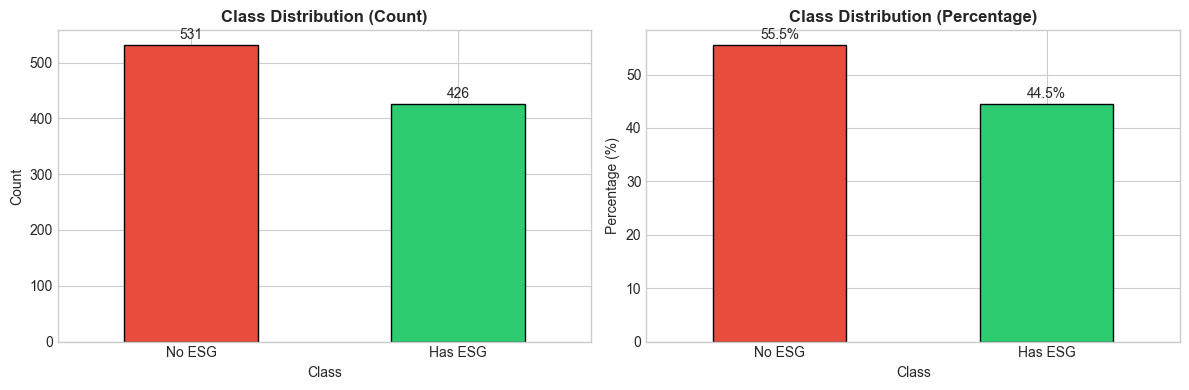

In [7]:
# Analyze target distribution
target_stats = analyze_target_stats(
    df, 
    TARGET_COL, 
    label_names=LABEL_NAMES,
    imbalance_threshold=5.0,
    save_path='images/ep_target_distribution.png'
)

## 3. Data Preprocessing & Train/Val/Test Split

We preprocess the text data first (creating text_features), then split into train/val/test sets. All subsequent EDA and feature engineering will use ONLY the training data to prevent data leakage. The validation dataset is used for feature engineering selection. The test data set is NOT used in this notebook.

In [8]:
# Create text features BEFORE splitting
# This combines title, brands, and content into a single cleaned text field
# Now includes source_name and category for metadata features
df['text_features'] = create_text_features(
    df,
    text_col='content',
    title_col='title',
    brands_col='brands',
    source_name_col='source_name',
    category_col='category',
    include_metadata=True,
    clean_func=clean_text
)

print("Text features created!")
print(f"Sample:\n{df['text_features'].iloc[0][:300]}...")

# Check for empty text features
empty_texts = (df['text_features'].str.len() == 0).sum()
print(f"\nRecords with empty text features: {empty_texts}")
if empty_texts > 0:
    df = df[df['text_features'].str.len() > 0].copy()
    print(f"Remaining records after removing empty: {len(df)}")

Text features created!
Sample:
insideretail.asia the factors behind lululemon ceo calvin mcdonald departure from the brand the factors behind lululemon ceo calvin mcdonald departure from the brand lululemon after seven years as ceo of athleisure giant lululemon retail veteran calvin mcdonald announced he would be leaving the comp...

Records with empty text features: 0


In [9]:
# Split with stratification
train_df, val_df, _ = split_train_val_test(
    df,
    target_col=TARGET_COL,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    random_state=RANDOM_STATE
)

# Extract features and targets
X_train = train_df['text_features']
y_train = train_df[TARGET_COL]

X_val = val_df['text_features']
y_val = val_df[TARGET_COL]

# Extract metadata for discrete metadata features
train_source_names = train_df['source_name'].tolist()
train_categories = train_df['category'].tolist()
val_source_names = val_df['source_name'].tolist()
val_categories = val_df['category'].tolist()

# Combine train+val for feature engineering comparison and tuning
# CV will create its own internal train/val splits, so we use 80% of data
X_trainval = pd.concat([X_train, X_val], ignore_index=True)
y_trainval = np.concatenate([y_train, y_val])
trainval_source_names = train_source_names + val_source_names
trainval_categories = train_categories + val_categories

print(f"\nDataset sizes:")
print(f"  Train: {len(X_train)} samples")
print(f"  Val:   {len(X_val)} samples")
print(f"  Train+Val (for CV): {len(X_trainval)} samples")

TRAIN/VALIDATION/TEST SPLIT

Total samples: 957

Split ratios: 60% / 20% / 20%

Resulting sizes:
  Train:      573 (59.9%)
  Validation: 192 (20.1%)
  Test:       192 (20.1%)

Class distribution (stratified by 'has_esg'):
  Train: 0: 55.5%, 1: 44.5%
  Val: 0: 55.2%, 1: 44.8%
  Test: 0: 55.7%, 1: 44.3%

Dataset sizes:
  Train: 573 samples
  Val:   192 samples
  Train+Val (for CV): 765 samples


## 4. Exploratory Data Analysis (TRAINING DATA ONLY)

All EDA from this point forward uses ONLY the training data to prevent data leakage.

### 4.1 Text Length Analysis

In [10]:
# Analyze text lengths (TRAINING DATA ONLY)
text_stats = analyze_text_length_stats(train_df, 'content', TARGET_COL)

TEXT LENGTH STATISTICS

Column: 'content'
Total records: 573

Overall statistics:
  Character length: mean=3428, median=2515, range=[140, 52711]
  Word count: mean=556, median=399, range=[22, 8910]

By has_esg:
  Class 1:
    Chars: mean=3805, median=3032
    Words: mean=611, median=475
  Class 0:
    Chars: mean=3125, median=1970
    Words: mean=512, median=328


Figure saved to images/ep_text_length_dist.png


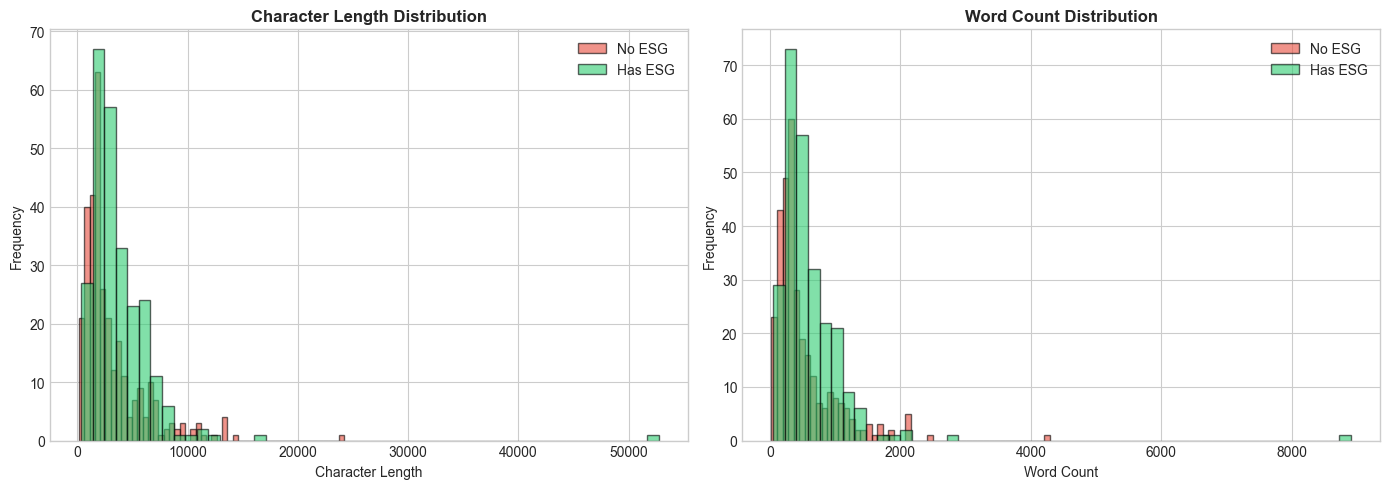

In [11]:
# Plot text length distributions by class (TRAINING DATA ONLY)
plot_text_length_distributions(
    train_df, 'content', TARGET_COL,
    label_names={0: 'No ESG', 1: 'Has ESG'},
    save_path='images/ep_text_length_dist.png'
)

### 4.2 Brand Distribution

In [12]:
# Analyze brand distribution (TRAINING DATA ONLY)
brand_counts = analyze_brand_distribution(train_df, 'brands', TARGET_COL, top_n=15)

BRAND DISTRIBUTION

Total brand mentions: 615
Unique brands: 38

Top 15 brands:
  Nike: 190 (30.9%)
  Lululemon: 82 (13.3%)
  Adidas: 58 (9.4%)
  Hoka: 42 (6.8%)
  Puma: 27 (4.4%)
  Skechers: 20 (3.3%)
  New Balance: 18 (2.9%)
  Timberland: 14 (2.3%)
  ASICS: 13 (2.1%)
  Reebok: 13 (2.1%)
  Patagonia: 12 (2.0%)
  Decathlon: 10 (1.6%)
  Under Armour: 9 (1.5%)
  Converse: 9 (1.5%)
  Vans: 8 (1.3%)

Brand distribution by has_esg:
  Class 0: 341 mentions, top: Nike (92), Hoka (38), Lululemon (32)
  Class 1: 274 mentions, top: Nike (98), Lululemon (50), Adidas (27)


Figure saved to images/ep_brand_dist.png


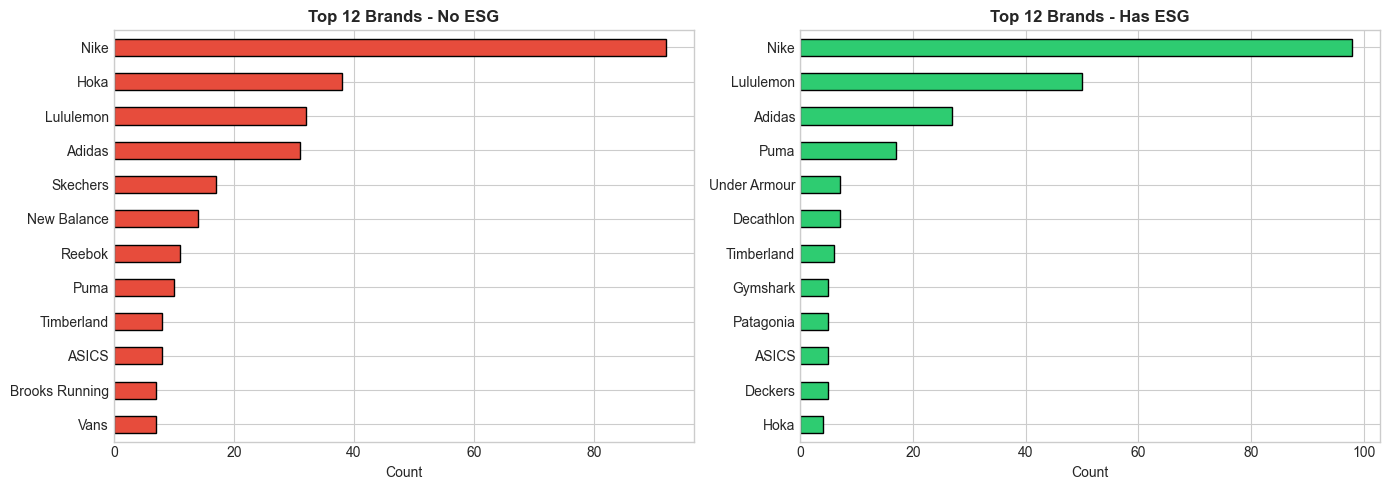

In [13]:
# Plot brand distribution by class (TRAINING DATA ONLY)
plot_brand_distribution(
    train_df, 'brands', TARGET_COL,
    label_names={0: 'No ESG', 1: 'Has ESG'},
    top_n=12,
    figsize=(14, 5),
    save_path='images/ep_brand_dist.png'
)

### 4.3 Word Frequency Analysis

In [14]:
# Analyze word frequencies by class (TRAINING DATA ONLY)
word_freqs = analyze_word_frequencies(train_df, 'content', TARGET_COL, top_n=15)

WORD FREQUENCY ANALYSIS

Top 15 words for class_0:
  nike: 473
  shoes: 426
  out: 403
  shoe: 400
  hoka: 380
  women: 378
  off: 361
  like: 359
  amazon: 341
  running: 335
  best: 321
  company: 316
  stock: 284
  sale: 283
  read: 280

Top 15 words for class_1:
  nike: 1,183
  company: 798
  year: 666
  brand: 603
  lululemon: 570
  shares: 532
  quarter: 531
  stock: 515
  price: 325
  billion: 318
  growth: 318
  sales: 289
  adidas: 279
  over: 277
  market: 273


In [15]:
# Look at some non-ESG examples (TRAINING DATA ONLY)
print("\n" + "="*60)
print("SAMPLE NON-ESG ARTICLES (from training data)")
print("="*60)

no_esg_train = train_df[train_df[TARGET_COL] == 0]
if len(no_esg_train) >= 3:
    samples = no_esg_train.sample(3, random_state=RANDOM_STATE)
else:
    samples = no_esg_train

for _, row in samples.iterrows():
    print(f"\nBrands: {row['brands']}")
    print(f"Title: {row['title'][:100]}...")
    if 'skip_reason' in row and pd.notna(row['skip_reason']):
        print(f"Skip Reason: {row['skip_reason']}")
    print("-" * 40)


SAMPLE NON-ESG ARTICLES (from training data)

Brands: ['Hoka']
Title: HOKA has its cloud - like Rincon 4 running shoe on sale for under $100...
----------------------------------------

Brands: ['Converse']
Title: Converse & Coke Team Up For New Shoe Collab | KAT 103 . 7FM | Steve & Gina in the Morning...
----------------------------------------

Brands: ['New Balance']
Title: New Balance announces Cooper Flagg new shoe...
Skip Reason: Product launch - New Balance Cooper Flagg shoe
----------------------------------------


## 5. Feature Engineering Comparison

We compare multiple feature engineering approaches using cross-validation on the combined training+validation data (80% of total). Since cross-validation creates its own internal train/val splits, using the full train+val set provides more data for reliable hyperparameter selection while keeping the test set completely held out.

We benchmark with three classifiers: Logistic Regression, LinearSVM, Random Forest, and HistGradientBoosting. This helps us select the best feature engineering approach before moving to model selection in the next notebook.

In [ ]:
# Define feature engineering approaches to compare
# Each config includes transformer parameters and optional tuning configuration
fe_configs = {
    'tfidf_lsa': {
        'method': 'tfidf_lsa',
        'max_features': 10000,
        'lsa_n_components': 100,
        'include_metadata_features': False,
        'tuning': {
            'param_name': 'lsa_n_components',
            'param_values': [50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300, 400],
            'description': 'LSA dimensionality'
        }
    },
    'tfidf_lsa_ner_proximity': {
        'method': 'tfidf_lsa_ner_proximity',
        'max_features': 10000,
        'lsa_n_components': 100,
        'proximity_window_size': 15,
        'include_metadata_features': False,
        'tuning': {
            'param_name': 'lsa_n_components',
            'param_values': [50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300, 400],
            'description': 'LSA dimensionality (with NER + proximity)'
        }
    },
    'tfidf_lsa_product': {
        'method': 'tfidf_lsa_product',
        'max_features': 10000,
        'lsa_n_components': 100,
        'proximity_window_size': 15,
        'include_metadata_features': False,
        'tuning': {
            'param_name': 'lsa_n_components',
            'param_values': [50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300, 400],
            'description': 'LSA dimensionality (with product detection)'
        }
    },
    # 'sentence_transformer': {
    #     'method': 'sentence_transformer',
    #     'sentence_model_name': 'all-MiniLM-L6-v2',
    #     'include_metadata_features': False,
    # },
    'sentence_transformer_ner': {
        'method': 'sentence_transformer_ner',
        'sentence_model_name': 'all-MiniLM-L6-v2',
        'include_metadata_features': False,
        'tuning': {
            'param_name': 'proximity_window_size',
            'param_values': [10, 15, 20, 25, 30],
            'description': 'NER proximity window size'
        }
    },
    'sentence_transformer_ner_vocab': {
        'method': 'sentence_transformer_ner_vocab',
        'sentence_model_name': 'all-MiniLM-L6-v2',
        'include_metadata_features': False,
        'tuning': {
            'param_name': 'proximity_window_size',
            'param_values': [10, 15, 20, 25, 30],
            'description': 'NER+vocab proximity window size'
        }
    },
}

print("Feature Engineering Approaches to Compare:")
print("=" * 50)
for name, config in fe_configs.items():
    print(f"  {name}: {config['method']}")
    if 'tuning' in config:
        tuning = config['tuning']
        print(f"    └─ Tuning: {tuning['param_name']} = {tuning['param_values']}")

In [17]:
# Evaluate each feature engineering approach using cross-validation
# Transformer is fitted on TRAINING data only (to prevent data leakage)
# CV is performed on TRAIN+VAL combined (CV creates internal splits)
f2_scorer = make_scorer(fbeta_score, beta=2)
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Define classifiers to benchmark
# Note: LinearSVC is used directly (not wrapped in CalibratedClassifierCV) because:
# 1. Our scoring uses decision_function for ranking metrics (PR-AUC)
# 2. Avoids nested CV overhead during hyperparameter tuning
# 3. Calibration is applied after model selection for probability estimates
classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(
            max_iter=2000,
            class_weight=None,
            random_state=RANDOM_STATE,
            solver='lbfgs'
        ),
        'requires_dense': False,
    },
    'LinearSVM': {
        'model': LinearSVC(
            max_iter=2000,
            random_state=RANDOM_STATE,
            class_weight=None
        ),
        'requires_dense': False,
    },
    'RandomForest': {
        'model': RandomForestClassifier(
            n_estimators=100,
            random_state=RANDOM_STATE,
            class_weight=None,
            n_jobs=-1
        ),
        'requires_dense': False,
    },
    'HistGradientBoosting': {
        'model': HistGradientBoostingClassifier(
            max_iter=100,
            max_depth=5,
            class_weight=None,
            random_state=RANDOM_STATE,
        ),
        'requires_dense': True,
    },
}

# Run feature engineering evaluation
fe_results = evaluate_feature_engineering(
    fe_configs=fe_configs,
    classifiers=classifiers,
    transformer_class=EPFeatureTransformer,
    X_train=X_train,
    X_trainval=X_trainval,
    y_trainval=y_trainval,
    cv=cv,
    scorer=f2_scorer,
    random_state=RANDOM_STATE,
)

Evaluating tfidf_lsa...
  Feature shape: (765, 100), sparse: False
  [LogisticRegression] CV F2: 0.7844 (+/- 0.0556)
  [LinearSVM] CV F2: 0.8250 (+/- 0.0344)
  [RandomForest] CV F2: 0.8183 (+/- 0.0322)
  [HistGradientBoosting] CV F2: 0.8109 (+/- 0.0434)
Evaluating tfidf_lsa_ner_proximity...
  Feature shape: (765, 114), sparse: False
  [LogisticRegression] CV F2: 0.7937 (+/- 0.0395)
  [LinearSVM] CV F2: 0.8196 (+/- 0.0253)
  [RandomForest] CV F2: 0.8193 (+/- 0.0398)
  [HistGradientBoosting] CV F2: 0.8038 (+/- 0.0468)
Evaluating tfidf_lsa_product...
  Feature shape: (765, 132), sparse: False
  [LogisticRegression] CV F2: 0.7964 (+/- 0.0216)
  [LinearSVM] CV F2: 0.8288 (+/- 0.0290)
  [RandomForest] CV F2: 0.8267 (+/- 0.0268)
  [HistGradientBoosting] CV F2: 0.8249 (+/- 0.0200)
Evaluating sentence_transformer_ner...
  Feature shape: (765, 390), sparse: False
  [LogisticRegression] CV F2: 0.7945 (+/- 0.0796)
  [LinearSVM] CV F2: 0.7960 (+/- 0.0562)
  [RandomForest] CV F2: 0.7648 (+/- 0.0547)

In [18]:
# Compare feature engineering results
fe_df = pd.DataFrame(fe_results)

# Create pivot table for easier comparison
pivot_df = fe_df.pivot_table(
    index='name',
    columns='classifier',
    values=['cv_f2', 'cv_recall', 'cv_precision'],
    aggfunc='first'
)

print("\n" + "=" * 80)
print("FEATURE ENGINEERING COMPARISON RESULTS")
print("=" * 80)

# Display results sorted by F2 score for each classifier
for clf_name in ['LogisticRegression', 'LinearSVM', 'RandomForest', 'HistGradientBoosting']:
    clf_df = fe_df[fe_df['classifier'] == clf_name].set_index('name')
    clf_df = clf_df.sort_values('cv_f2', ascending=False)
    print(f"\n{clf_name} Results:")
    print(clf_df[['n_features', 'cv_f2', 'cv_f2_std', 'cv_recall', 'cv_precision']])

print("=" * 80)

# Determine best overall
best_row = fe_df.loc[fe_df['cv_f2'].idxmax()]
best_fe = best_row['name']
best_clf = best_row['classifier']
print(f"\nBest combination: {best_fe} + {best_clf}")
print(f"  CV F2: {best_row['cv_f2']:.4f}")
print(f"  Features: {int(best_row['n_features'])}")


FEATURE ENGINEERING COMPARISON RESULTS

LogisticRegression Results:
                                n_features     cv_f2  cv_f2_std  cv_recall  \
name                                                                         
tfidf_lsa_product                      132  0.796376   0.021614   0.803602   
sentence_transformer_ner               390  0.794450   0.079621   0.797909   
tfidf_lsa_ner_proximity                114  0.793742   0.039520   0.789008   
sentence_transformer_ner_vocab         401  0.784892   0.032681   0.789008   
tfidf_lsa                              100  0.784395   0.055649   0.771490   

                                cv_precision  
name                                          
tfidf_lsa_product                   0.770962  
sentence_transformer_ner            0.787181  
tfidf_lsa_ner_proximity             0.814772  
sentence_transformer_ner_vocab      0.771084  
tfidf_lsa                           0.841990  

LinearSVM Results:
                                n_f

Figure saved to /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_fe_comparison.png


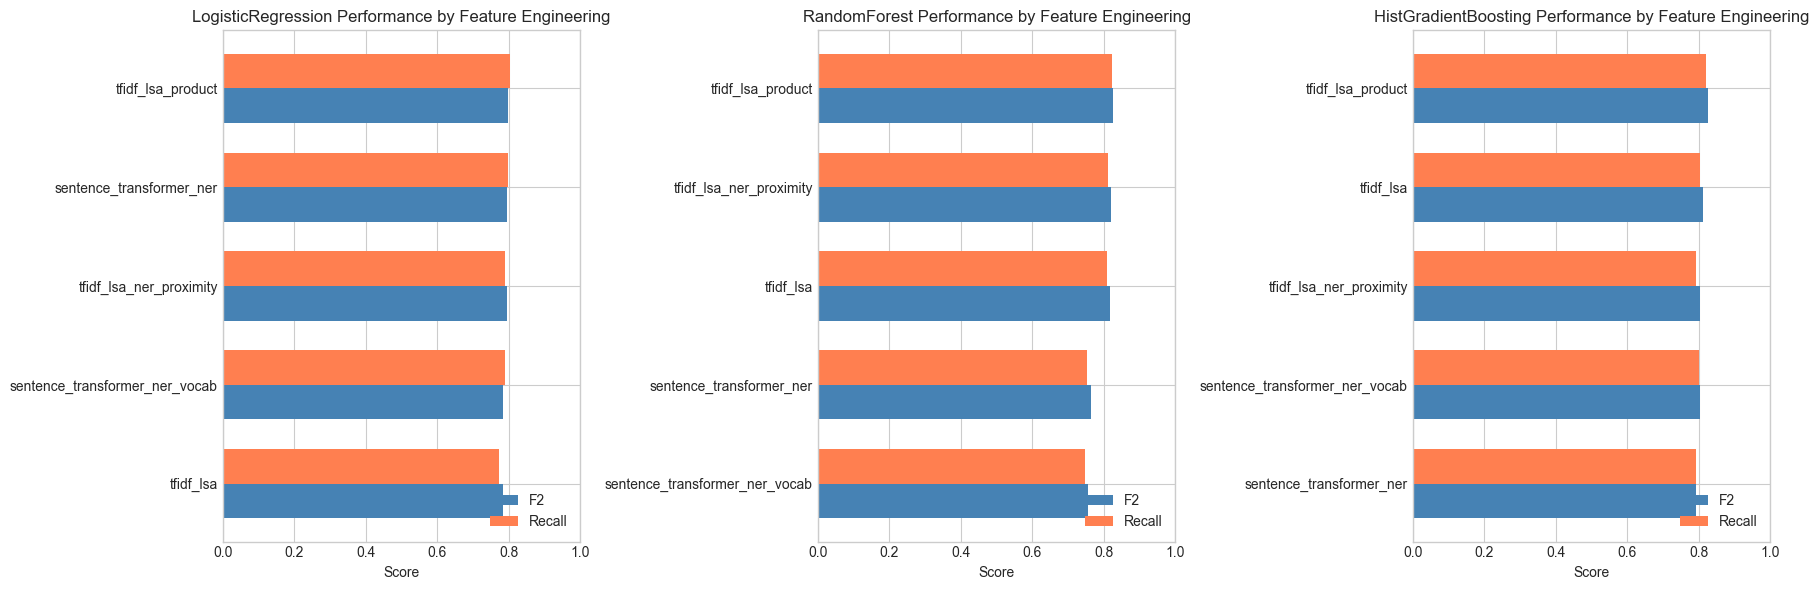

In [19]:
# Visualize comparison - show both classifiers side by side
plot_fe_comparison(fe_df, save_path=MODELS_DIR / 'ep_fe_comparison.png')

## 5.1 Feature Transformer Hyperparameter Tuning

Based on the comparison results above, we tune the key hyperparameter for the best-performing feature engineering method.

In [ ]:
# Extract tuning configs from fe_configs for the tuning function
tuning_configs = {
    name: config['tuning']
    for name, config in fe_configs.items()
    if 'tuning' in config
}

# Run hyperparameter tuning for the best feature transformer
tuning_df, optimal_param_value, best_tuned_f2 = run_transformer_tuning(
    best_fe=best_fe,
    best_clf=best_clf,
    fe_configs=fe_configs,
    tuning_configs=tuning_configs,
    classifiers=classifiers,
    transformer_class=EPFeatureTransformer,
    X_train=X_train,
    X_trainval=X_trainval,
    y_trainval=y_trainval,
    cv=cv,
    scorer=f2_scorer,
    images_dir=IMAGES_DIR,
    random_state=RANDOM_STATE,
    n_folds=N_FOLDS,
)

## 6. Pipeline Export

Create and export the best feature transformer for use in the model selection notebook.

In [ ]:
# Create the best transformer with optimal hyperparameters from tuning
print(f"Selected feature engineering approach: {best_fe}")
print(f"Base configuration: {fe_configs[best_fe]}")

# Create final config with optimal hyperparameters (exclude 'tuning' key)
final_config = {k: v for k, v in fe_configs[best_fe].items() if k != 'tuning'}
tuning_info = fe_configs[best_fe].get('tuning')
if tuning_info and optimal_param_value is not None:
    param_name = tuning_info['param_name']
    final_config[param_name] = optimal_param_value
    print(f"Optimal {param_name}: {optimal_param_value}")

# Create transformer with best configuration
final_transformer = EPFeatureTransformer(**final_config, random_state=RANDOM_STATE)

# Fit on training data
X_train_final = final_transformer.fit_transform(X_train)
print(f"\nFinal feature shape: {X_train_final.shape}")

# Verify by transforming validation data
X_val_final = final_transformer.transform(X_val)
print(f"Validation feature shape: {X_val_final.shape}")

In [22]:
# Save the fitted transformer
transformer_path = MODELS_DIR / 'ep_feature_transformer.joblib'
joblib.dump(final_transformer, transformer_path)
print(f"Transformer saved to: {transformer_path}")

# Save configuration for reproducibility
config_path = MODELS_DIR / 'ep_feature_config.json'
final_transformer.save_config(config_path)
print(f"Configuration saved to: {config_path}")

# Also save the comparison results
results_path = MODELS_DIR / 'ep_fe_comparison.json'
with open(results_path, 'w') as f:
    json.dump(fe_results, f, indent=2)
print(f"Comparison results saved to: {results_path}")

Transformer saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_feature_transformer.joblib
Configuration saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_feature_config.json
Comparison results saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/ep_fe_comparison.json


## 7. Summary

In [ ]:
print("=" * 60)
print("NOTEBOOK SUMMARY")
print("=" * 60)
print(f"\nDataset: {len(df)} articles")
print(f"  - Training: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  - Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"  - Train+Val (used for CV): {len(X_trainval)} ({len(X_trainval)/len(df)*100:.1f}%)")
print(f"\nClass distribution (training):")
print(f"  - Has ESG: {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")
print(f"  - No ESG: {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")

# Report best results - use tuned values if tuning was performed
print(f"\nBest Feature Engineering: {best_fe}")
print(f"  - Best Classifier: {best_clf}")

# Use tuned score and feature count if tuning was done, otherwise use baseline
tuning_info = fe_configs[best_fe].get('tuning')
if tuning_info and optimal_param_value is not None:
    param_name = tuning_info['param_name']
    print(f"  - CV F2 Score: {best_tuned_f2:.4f} (after tuning)")
    print(f"  - Features: {X_train_final.shape[1]}")
    print(f"  - Optimal {param_name}: {optimal_param_value}")
else:
    print(f"  - CV F2 Score: {best_row['cv_f2']:.4f}")
    print(f"  - Features: {int(best_row['n_features'])}")

print(f"\nArtifacts saved:")
print(f"  - {MODELS_DIR / 'ep_feature_transformer.joblib'}")
print(f"  - {MODELS_DIR / 'ep_feature_config.json'}")
print(f"  - {MODELS_DIR / 'ep_fe_comparison.json'}")
print(f"\nNext: Run ep2_model_selection_tuning.ipynb for model selection and hyperparameter tuning")
print("=" * 60)